In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols

In [2]:
dataset = pd.read_csv(r'../../data/processed/charity_main_cleaned.csv')
birm_disposal = pd.read_excel(r'../../data/raw/birm_Disposal( in period 09052025).xlsx')

In [ ]:
df = dataset[dataset['local_authority'] == 'Birmingham']

In [3]:
dwelling_types = [
    'DWELLINGHOUSE',
    'DWELLINGHOUSE AND GARAGE',
    'DWELLINGHOUSE AND LAND'
]

dwellings = birm_disposal[birm_disposal['TYPEPROP'].isin(dwelling_types)]
non_dwellings = birm_disposal[~birm_disposal['TYPEPROP'].isin(dwelling_types)]


C:\Users\User\AppData\Local\Temp\ipykernel_12420\946858284.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwellings['DISPLDATE'] = pd.to_datetime(dwellings['DISPLDATE'].astype(str), format='%Y%m%d')
C:\Users\User\AppData\Local\Temp\ipykernel_12420\946858284.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_dwellings['DISPLDATE'] = pd.to_datetime(non_dwellings['DISPLDATE'].astype(str), format='%Y%m%d')


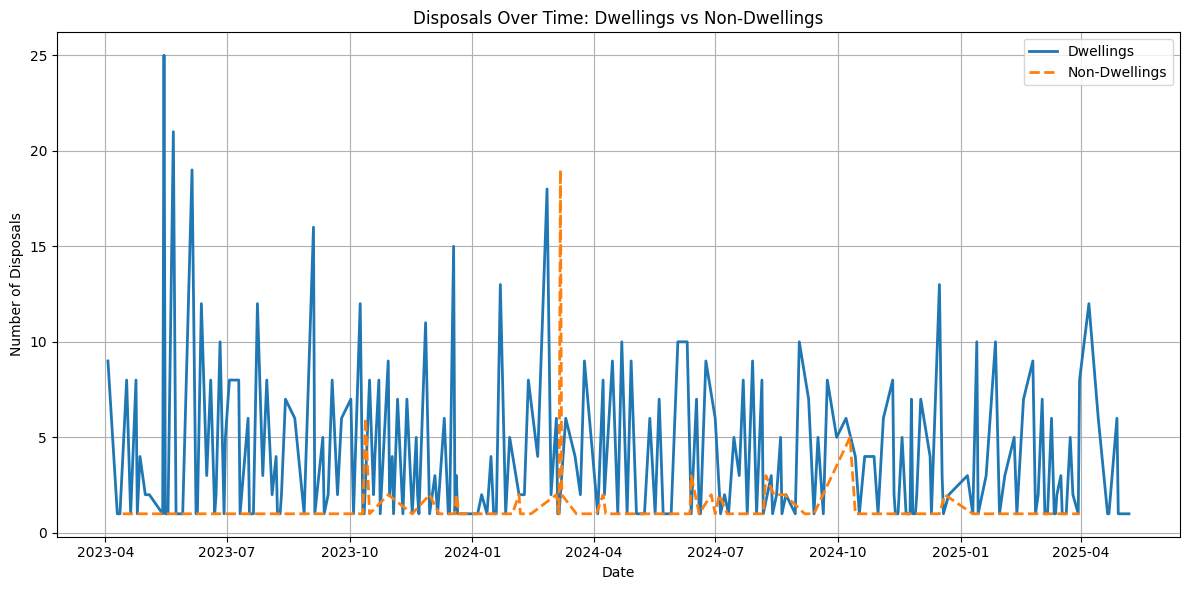

In [4]:
# Convert to datetime from YYYYMMDD format
dwellings['DISPLDATE'] = pd.to_datetime(dwellings['DISPLDATE'].astype(str), format='%Y%m%d')
non_dwellings['DISPLDATE'] = pd.to_datetime(non_dwellings['DISPLDATE'].astype(str), format='%Y%m%d')

# Count disposals per day
dwelling_counts = dwellings['DISPLDATE'].value_counts().sort_index()
non_dwelling_counts = non_dwellings['DISPLDATE'].value_counts().sort_index()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(dwelling_counts.index, dwelling_counts.values, label='Dwellings', linewidth=2)
plt.plot(non_dwelling_counts.index, non_dwelling_counts.values, label='Non-Dwellings', linewidth=2, linestyle='--')

plt.xlabel('Date')
plt.ylabel('Number of Disposals')
plt.title('Disposals Over Time: Dwellings vs Non-Dwellings')
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


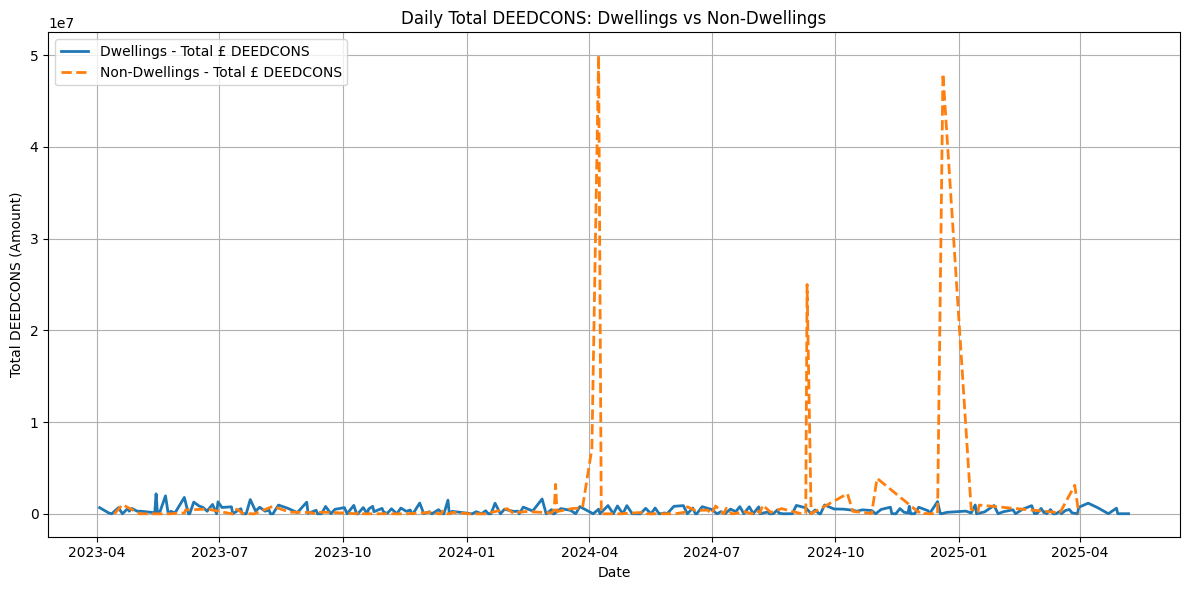

In [9]:
# 2. Group by date and sum DEEDCONS values (not counts)
dwelling_sums = dwellings.groupby('DISPLDATE')['DEEDCONS'].sum()
non_dwelling_sums = non_dwellings.groupby('DISPLDATE')['DEEDCONS'].sum()

# 3. Plot both on the same timeline
plt.figure(figsize=(12, 6))
plt.plot(dwelling_sums.index, dwelling_sums.values, label='Dwellings - Total £ DEEDCONS', linewidth=2)
plt.plot(non_dwelling_sums.index, non_dwelling_sums.values, label='Non-Dwellings - Total £ DEEDCONS', linewidth=2, linestyle='--')

plt.xlabel('Date')
plt.ylabel('Total DEEDCONS (Amount)')
plt.title('Daily Total DEEDCONS: Dwellings vs Non-Dwellings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
dwellings['DEEDCONS']

0       107250.0
1       100750.0
2        69930.0
3        67800.0
4        63000.0
          ...   
1043     80500.0
1044    110200.0
1045    100750.0
1046      7000.0
1047      8000.0
Name: DEEDCONS, Length: 907, dtype: float64

In [ ]:
birm_disposal['TYPEPROP'].unique()

In [5]:
birm_disposal.columns

Index(['IPMSREF', 'LLPGREF', 'TYPEPROP', 'ADDRPROP', 'TOWN', 'COUNTY',
       'POSTCODE', 'WARD', 'CONSTIT', 'DISPLDATE', 'DEEDCONS', 'TYPECONSD',
       'INTEREST'],
      dtype='object')

In [ ]:
df.columns

In [ ]:
# --- Parameters ---
treatment_date = pd.to_datetime("2023-09-05")  # your treatment date
birm_disposal['DISPLDATE'] = pd.to_datetime(birm_disposal['DISPLDATE'].astype(str), format='%Y%m%d', errors='coerce')


In [ ]:
monthly_disposals = (
    birm_disposal['DISPLDATE']
    .dt.to_period('M')
    .value_counts()
    .sort_index()
    .rename('count')
    .to_frame()
)
monthly_disposals.index = monthly_disposals.index.to_timestamp()
monthly_disposals.index.name = 'month'
monthly_disposals = monthly_disposals.asfreq('MS', fill_value=0)

# Step 2: Create pre/post indicator
monthly_disposals['post'] = (monthly_disposals.index >= treatment_date).astype(int)

# Step 3: Create lead and lag indicators (3 months before and after)
monthly_disposals['lead_3'] = (monthly_disposals.index < treatment_date - pd.DateOffset(months=2)).astype(int)
monthly_disposals['lead_2'] = ((monthly_disposals.index >= treatment_date - pd.DateOffset(months=2)) & 
                               (monthly_disposals.index < treatment_date - pd.DateOffset(months=1))).astype(int)
monthly_disposals['lead_1'] = ((monthly_disposals.index >= treatment_date - pd.DateOffset(months=1)) & 
                               (monthly_disposals.index < treatment_date)).astype(int)
monthly_disposals['lag_0'] = (monthly_disposals.index == treatment_date.replace(day=1)).astype(int)
monthly_disposals['lag_1'] = ((monthly_disposals.index > treatment_date) & 
                              (monthly_disposals.index <= treatment_date + pd.DateOffset(months=1))).astype(int)
monthly_disposals['lag_2'] = ((monthly_disposals.index > treatment_date + pd.DateOffset(months=1)) & 
                              (monthly_disposals.index <= treatment_date + pd.DateOffset(months=2))).astype(int)
monthly_disposals['lag_3'] = (monthly_disposals.index > treatment_date + pd.DateOffset(months=2)).astype(int)

# Step 4: Run regression with leads/lags
formula = 'count ~ lead_3 + lead_2 + lead_1 + lag_0 + lag_1 + lag_2 + lag_3'
model = ols(formula, data=monthly_disposals).fit()
model_summary = model.summary()

model_summary


In [ ]:
import matplotlib.pyplot as plt

# Assume daily_disposals_monthly is already grouped and includes 'post' indicator
# Plot line graph of monthly disposal count

plt.figure(figsize=(12, 5))
monthly_disposals['count'].plot(marker='o', linestyle='-')
plt.axvline(treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.title('Monthly Asset Disposals (Birmingham City Council)')
plt.xlabel('Month')
plt.ylabel('Number of Disposals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(12, 5))
daily_disposals['count'].plot(marker='o', linestyle='-')
plt.axvline(treatment_date, color='red', linestyle='--', label='Treatment Date')
plt.title('Monthly Asset Disposals (Birmingham City Council)')
plt.xlabel('Month')
plt.ylabel('Number of Disposals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
monthly_disposals['time'] = range(len(monthly_disposals))
monthly_disposals['post_time'] = monthly_disposals['time'] * monthly_disposals['post']

In [ ]:
import statsmodels.api as sm

X = sm.add_constant(monthly_disposals[['time', 'post', 'post_time']])
y = monthly_disposals['count']
model = sm.OLS(y, X).fit()
model.summary()


In [ ]:
from statsmodels.formula.api import ols
import numpy as np

# Step 1: Define breakpoint
breakpoint = '2023-09-01'
pre = monthly_disposals[monthly_disposals.index < breakpoint]
post = monthly_disposals[monthly_disposals.index >= breakpoint]

# Step 2: Run regressions
model_full = ols('count ~ time', data=monthly_disposals).fit()
model_pre = ols('count ~ time', data=pre).fit()
model_post = ols('count ~ time', data=post).fit()

# Step 3: Chow test statistic
SSR_full = sum(model_full.resid ** 2)
SSR_pre = sum(model_pre.resid ** 2)
SSR_post = sum(model_post.resid ** 2)

k = model_full.df_model + 1  # number of parameters
n_pre = len(pre)
n_post = len(post)

numerator = (SSR_full - (SSR_pre + SSR_post)) / k
denominator = (SSR_pre + SSR_post) / (n_pre + n_post - 2 * k)
chow_stat = numerator / denominator

from scipy.stats import f
p_value = 1 - f.cdf(chow_stat, k, n_pre + n_post - 2 * k)

print(f'Chow Test Statistic: {chow_stat:.4f}')
print(f'P-value: {p_value:.4f}')


In [ ]:
daily_disposals = birm_disposal['DISPLDATE'].value_counts().sort_index().rename('count').to_frame()
daily_disposals.index.name = 'date'
daily_disposals = daily_disposals.asfreq('D', fill_value=0)
break_date = pd.Timestamp("2023-09-05")

pre = daily_disposals[daily_disposals.index < break_date]
post = daily_disposals[daily_disposals.index >= break_date]

# Add a time trend if needed
pre = pre.copy()
post = post.copy()
pre['time'] = range(len(pre))
post['time'] = range(len(post))
from statsmodels.api import OLS, add_constant
from scipy.stats import f

# Fit models
X_pre = add_constant(pre['time'])
X_post = add_constant(post['time'])
y_pre = pre['count']
y_post = post['count']

model_full = OLS(daily_disposals['count'], add_constant(range(len(daily_disposals)))).fit()
model_pre = OLS(y_pre, X_pre).fit()
model_post = OLS(y_post, X_post).fit()

# Chow test calculation
RSS_pooled = sum(model_full.resid**2)
RSS_pre = sum(model_pre.resid**2)
RSS_post = sum(model_post.resid**2)

k = X_pre.shape[1]  # number of parameters
n_pre = len(y_pre)
n_post = len(y_post)

numerator = (RSS_pooled - (RSS_pre + RSS_post)) / k
denominator = (RSS_pre + RSS_post) / (n_pre + n_post - 2 * k)
chow_stat = numerator / denominator
p_value = 1 - f.cdf(chow_stat, k, n_pre + n_post - 2 * k)

print(f"Chow Test Statistic: {chow_stat:.4f}")
print(f"P-value: {p_value:.4f}")


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Aggregate to weekly disposal count ---
birm_disposal['DISPLDATE'] = pd.to_datetime(birm_disposal['DISPLDATE'])
weekly_disposals = (
    birm_disposal.set_index('DISPLDATE')
    .resample('W-MON')  # Weeks starting Monday
    .size()
    .rename('count')
    .to_frame()
)

# --- Step 2: Calculate week relative to treatment date ---
treatment_date = pd.Timestamp("2023-09-05")
reference_monday = treatment_date - pd.DateOffset(days=treatment_date.weekday())  # align to start of week

weekly_disposals['relative_week'] = (
    (weekly_disposals.index - reference_monday) / pd.Timedelta(weeks=1)
).round().astype(int)

# --- Step 3: Create lead/lag dummies with safe names ---
window = 8  # e.g. ±8 weeks
for i in range(-window, window + 1):
    var_name = f"week_p{i}" if i >= 0 else f"week_m{-i}"
    weekly_disposals[var_name] = (weekly_disposals['relative_week'] == i).astype(int)

# --- Step 4: Drop the baseline (e.g. week before treatment, i = -1) ---
baseline_var = "week_m1"
event_vars = [col for col in weekly_disposals.columns if col.startswith("week_") and col != baseline_var]

# --- Step 5: Run regression ---
formula = "count ~ " + " + ".join(event_vars)
model = smf.ols(formula, data=weekly_disposals).fit()
print(model.summary())

# --- Step 6: Plot coefficients ---
coefs = model.params[event_vars]
conf_int = model.conf_int().loc[event_vars]
errors = coefs - conf_int[0]  # symmetric error bars

plt.figure(figsize=(12, 6))
coefs.plot(kind='bar', yerr=errors, capsize=4, color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.title("Weekly Effect on Asset Disposals (Relative to Week -1)")
plt.ylabel("Change in Disposal Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# Step 1: Create first difference of disposal counts
weekly_disposals['count_diff'] = weekly_disposals['count'].diff()

# Step 2: Drop first row (now NaN after differencing)
weekly_disposals = weekly_disposals.dropna(subset=['count_diff'])

# Step 3: Run the same event-study model on the differenced series
event_vars = [f"week_{i:+d}".replace("+", "p").replace("-", "m") for i in range(-8, 9) if i != -1]
formula = "count_diff ~ " + " + ".join(event_vars)

model = smf.ols(formula=formula, data=weekly_disposals).fit()
model.summary()


In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Aggregate to weekly disposal count ---
birm_disposal['DISPLDATE'] = pd.to_datetime(birm_disposal['DISPLDATE'])
weekly_disposals = (
    birm_disposal.set_index('DISPLDATE')
    .resample('W-MON')  # Weeks starting Monday
    .size()
    .rename('count')
    .to_frame()
)

# --- Step 1.1: Log-transform the count (add 1 to avoid log(0)) ---
weekly_disposals['log_count'] = np.log1p(weekly_disposals['count'])

# --- Step 2: Calculate week relative to treatment date ---
treatment_date = pd.Timestamp("2023-09-05")
reference_monday = treatment_date - pd.DateOffset(days=treatment_date.weekday())

weekly_disposals['relative_week'] = (
    (weekly_disposals.index - reference_monday) / pd.Timedelta(weeks=1)
).round().astype(int)

# --- Step 3: Create lead/lag dummies with safe names ---
window = 8
for i in range(-window, window + 1):
    var_name = f"week_p{i}" if i >= 0 else f"week_m{-i}"
    weekly_disposals[var_name] = (weekly_disposals['relative_week'] == i).astype(int)

# --- Step 4: Drop baseline week (-1) ---
baseline_var = "week_m1"
event_vars = [col for col in weekly_disposals.columns if col.startswith("week_") and col != baseline_var]

# --- Step 5: Run regression using log_count as outcome ---
formula = "log_count ~ " + " + ".join(event_vars)
model = smf.ols(formula, data=weekly_disposals).fit()
print(model.summary())

# --- Step 6: Plot coefficients ---
coefs = model.params[event_vars]
conf_int = model.conf_int().loc[event_vars]
errors = coefs - conf_int[0]

plt.figure(figsize=(12, 6))
coefs.plot(kind='bar', yerr=errors, capsize=4, color='skyblue')
plt.axhline(0, color='black', linewidth=1)
plt.title("Log Weekly Effect on Asset Disposals (Relative to Week -1)")
plt.ylabel("Change in log(count + 1)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
